## Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import io
import json
import shutil
import zipfile
import requests

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm.auto import trange
import matplotlib.pyplot as plt

from scipy.signal import welch
from scipy.stats import kurtosis, skew
from scipy.signal.windows import blackman

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingClassifier, VotingClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model

## Загрузка и первичная обработка данных

#### Загрузка данных с GitHub

In [2]:
url = "https://github.com/tiiuae/UAV-Realistic-Fault-Dataset/archive/refs/heads/main.zip"
response = requests.get(url)

zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall("UAV-Realistic-Fault-Dataset")

#### Парсинг данных

In [3]:
base_dir = r'UAV-Realistic-Fault-Dataset\UAV-Realistic-Fault-Dataset-main\Dataset'
processed_dir = 'ProcessedDataset'
os.makedirs(processed_dir, exist_ok=True)

for folder in trange(5, desc='Progress', colour='blue'):
    folder_path = os.path.join(base_dir, str(folder))
    file_number = 0
    
    class_folder = os.path.join(processed_dir, str(folder))
    os.makedirs(class_folder, exist_ok=True)

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            combined_data = []
            
            for file in os.listdir(subfolder_path):
                if file.endswith('SensorCombined.jsonl'):
                    
                    with open(os.path.join(subfolder_path, file), 'r') as jsonl_file:
                        for line in jsonl_file:
                            data = json.loads(line)
                            combined_data.append(data)

                        df = pd.DataFrame(combined_data)                        
                        for i, row in enumerate(df['gyro_rad']):
                            df.loc[i, ['gx', 'gy', 'gz']] = row
                            
                        for i, row in enumerate(df['accelerometer_m_s2']):
                            df.loc[i, ['ax', 'ay', 'az']] = row

                        df.drop(columns=["gyro_rad", "accelerometer_m_s2", 
                                         "accelerometer_timestamp_relative", 
                                         "accelerometer_clipping"], inplace=True)
                        
                        df.rename(columns={'timestamp': 'time', 
                                           'gyro_integral_dt': 'gInt', 
                                           'accelerometer_integral_dt': 'aInt'}, inplace=True)
                        
                        df.to_csv(os.path.join(class_folder, f"class_{folder}_number_{file_number}.csv"), index=False)
                        file_number += 1

    combined_class_data = []
    for file in os.listdir(class_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(class_folder, file)
            class_df = pd.read_csv(file_path)
            combined_class_data.append(class_df)

    if combined_class_data:
        final_df = pd.concat(combined_class_data, ignore_index=True)
        final_df.to_csv(os.path.join(class_folder, f"data_{folder}.csv"), index=False)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
# Убедимся, что данные корректно записались
test_data = pd.read_csv(r"ProcessedDataset\0\data_0.csv")
test_data.head(5)

time  gInt  aInt        gx        gy        gz        ax        ay  \
0  947975062  4998  4998  0.008529  0.004348 -0.001269  0.145165 -0.034807   
1  947976312  4996  4996  0.001431  0.005915 -0.001310  0.116024  0.020439   
2  947983469  4998  4998  0.016173  0.007350  0.000573  0.092866  0.060234   
3  947996546  4994  4994 -0.001588  0.000100 -0.003505  0.065213  0.016342   
4  947995456  4995  4995  0.008024  0.012801  0.000042  0.082880  0.064342   

         az  
0 -9.828311  
1 -9.769987  
2 -9.827328  
3 -9.804899  
4 -9.800008

#### Удаление ненужных данных

In [5]:
folder_path = 'UAV-Realistic-Fault-Dataset'
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)

## Анализ данных

#### Вычисление частоты дискретизации

Частота дискретизации акселерометра и гироскопа нигде не указана, поэтому вычислим её самостоятельно.

In [6]:
lst = []
for clas in range(5):
    for num in range(20):
        
        if clas == 0 and num == 19: continue                                           # Так как в классе "0" меньше на 1 файл
        data = pd.read_csv(rf"ProcessedDataset\{clas}\class_{clas}_number_{num}.csv")  # Считываем данные
        data = data.sort_values(by='time')                                             # Сортируем по времени
        time_differences = (data['time'].diff().abs()).dropna()                        # Рассчитываем разницу между всеми соседними
        average_difference = time_differences.mean() / 10**6                           # Переводим в секунды из микросекунд
        lst.append(1 / average_difference)                                             # Сохраняем

print(f"Рассчитанная частота дискретизации: {round(sum(lst) / len(lst))}")

Рассчитанная частота дискретизации: 195


#### Построение 3D спектрограмм

In [7]:
def plot_3d_spectrogram(clas, window_size=256):
    """
    Строит 3D спектрограмму для заданного класса данных.

    Параметры:
    clas (str): Имя класса, для которого будет построена спектрограмма.
    window_size (int, optional): Размер окна для обработки данных. 
                                  По умолчанию 256.

    Возвращает:
    None: Функция отображает графики, но не возвращает никаких значений.
    
    Описание:
    Функция считывает данные из CSV файла, применяет оконную функцию Блэкмана-Наталла,
    выполняет быстрое преобразование Фурье (БПФ) для перекрывающихся сегментов данных 
    и строит 3D спектрограммы для каждого канала данных (gx, gy, gz, ax, ay, az).
    Каждая спектрограмма отображает амплитуды в зависимости от частоты и времени.
    """
    
    channels = ["gx", "gy", "gz", "ax", "ay", "az"]
    data = pd.read_csv(rf"ProcessedDataset\{clas}\data_{clas}.csv")[["time", *channels]].values
    data[:, 6] += 9.81

    Fs = 195                    # Частота дискретизации
    N = len(data)               # Количество строк данных
    overlap = window_size // 2  # Наложение окон (50%)
    
    num_windows = (N - overlap) // (window_size - overlap)  # Количество всех окон
    amplitude = np.empty((num_windows, window_size, 6))     # Массив для амплитуд
    xf = np.fft.fftfreq(window_size, 1 / Fs)                # Получение частот для спектра
    window = blackman(window_size)                          # Окно Блэкмана-Наталла
    
    for i in range(num_windows):
        # Разбивка данных на перекрывающиеся сегменты
        start = i * (window_size - overlap)
        end = start + window_size
        segment = data[start:end, :]

        # Сортировка по времени и проверка "стыков" между разными фрагментами данных
        segment = pd.DataFrame(segment, columns=["time", *channels]).sort_values(by='time')
        time_differences = (segment['time'].diff().abs()).dropna()
        if max(time_differences) > 150000: continue
        segment = segment.drop(columns=["time"]).values  

        if segment.shape[0] == window_size:
            segment_windowed = segment * window[:, None]  # Наложение окна
            yf = np.fft.fft(segment_windowed, axis=0)     # Применение БПФ
            amplitude[i] = np.abs(yf)                     # Извлечение амплитуд

    # Отрисовка графиков
    fig = plt.figure(figsize=(20, 14))
    
    for i in range(6):
        ax = fig.add_subplot(2, 3, i + 1, projection='3d')
        
        time_axis = np.arange(num_windows)
        frequency_axis = xf[:window_size // 2]
        amplitude_channel = amplitude[:, :window_size // 2, i]
        time_axis_grid, frequency_axis_grid = np.meshgrid(time_axis, frequency_axis)
        
        ax.plot_surface(time_axis_grid, frequency_axis_grid, amplitude_channel.T, cmap='viridis')
        ax.set_title(f'3D Спектрограмма для {channels[i]}, class {clas}', size=12)
        ax.set_xlabel('Номер окна')
        ax.set_ylabel('Частота (Гц)')
        ax.set_zlabel('Амплитуда')
        
    # plt.savefig(f'3D_spectrogram_class_{clas}.png', dpi=300, bbox_inches='tight')
    plt.show()

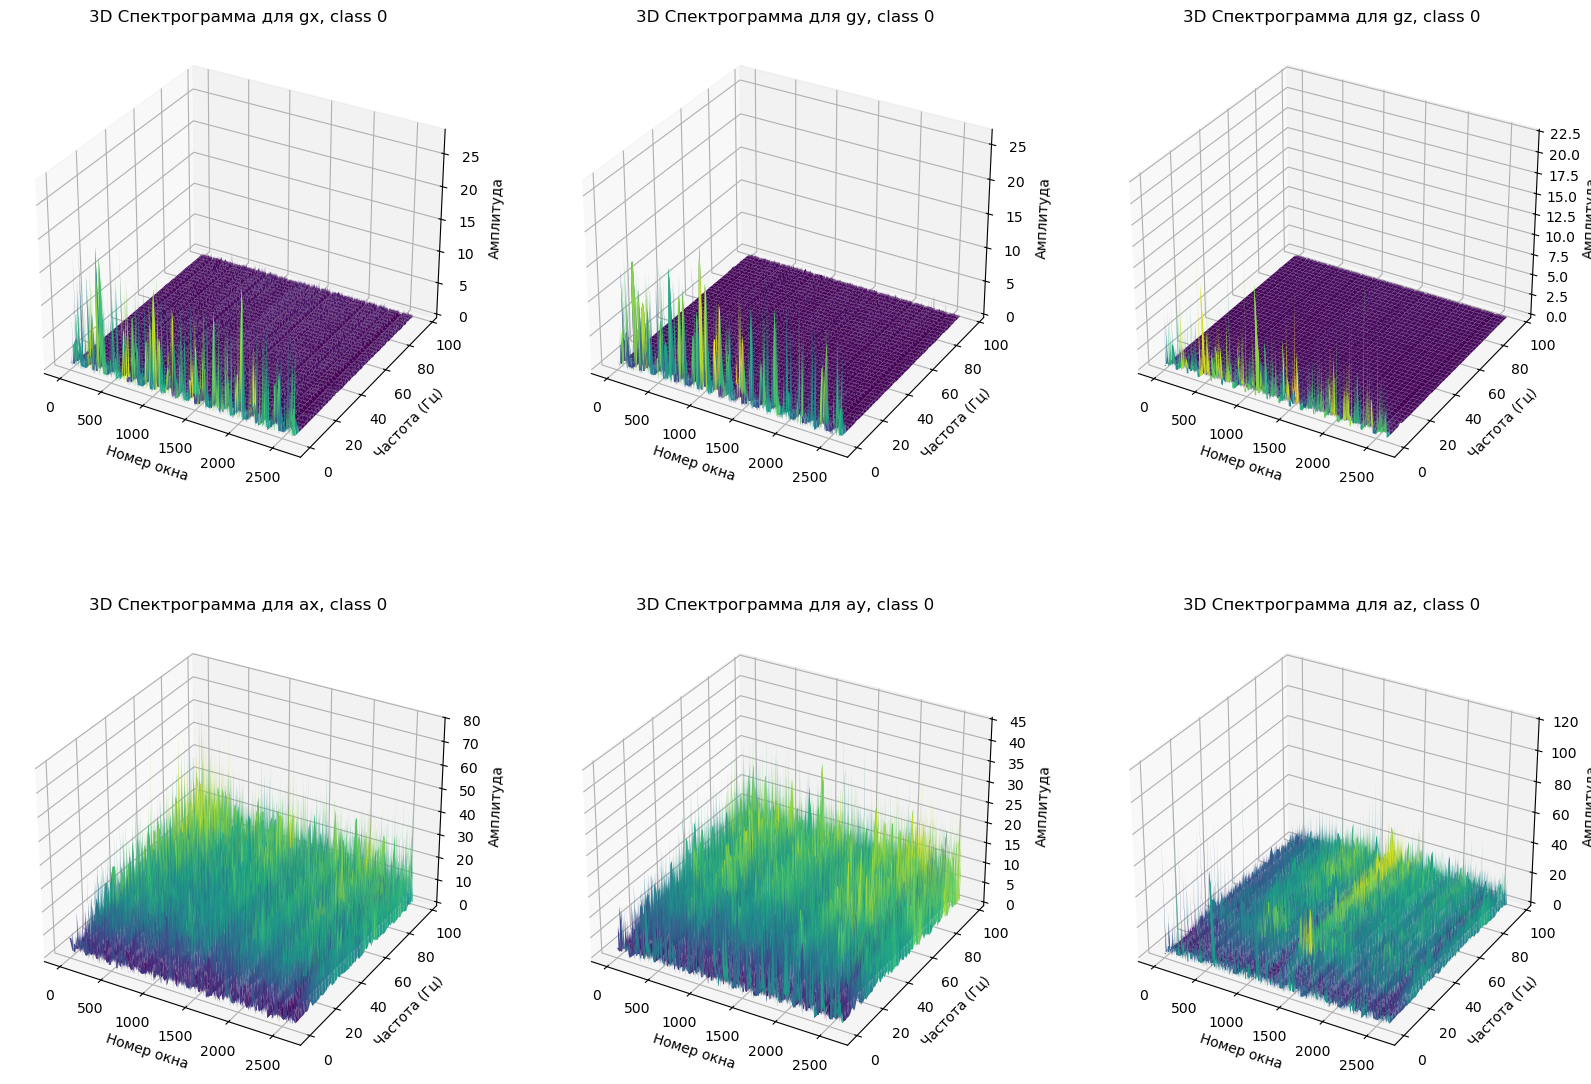

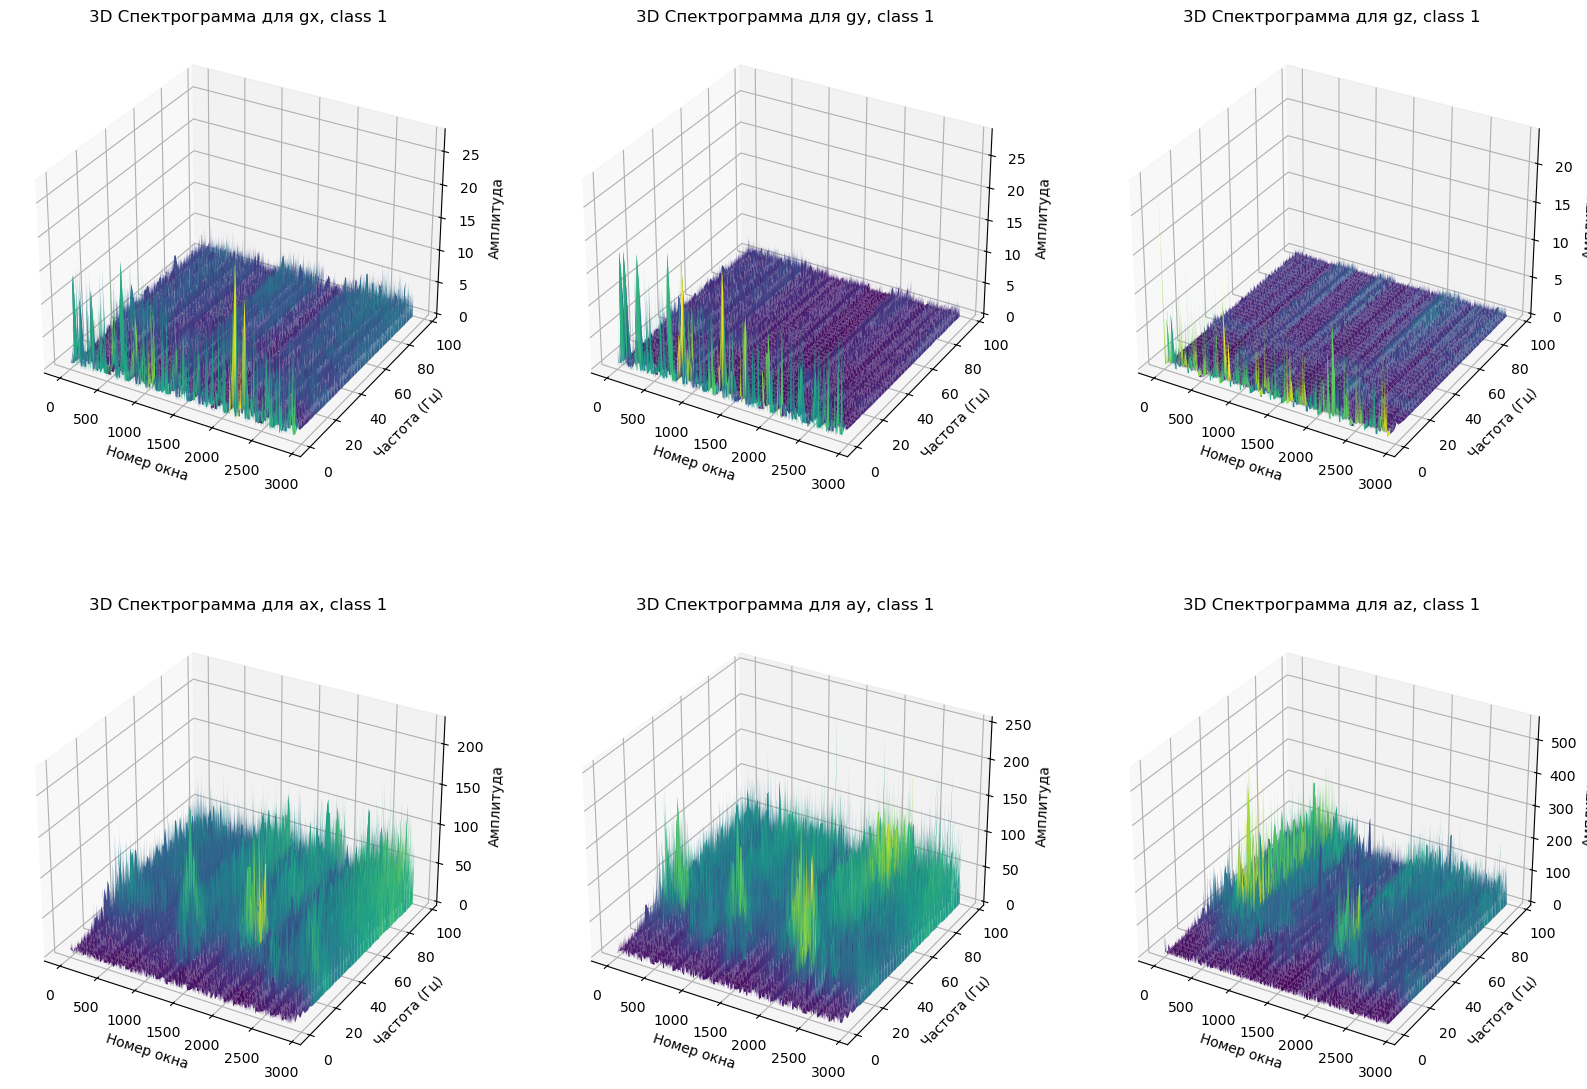

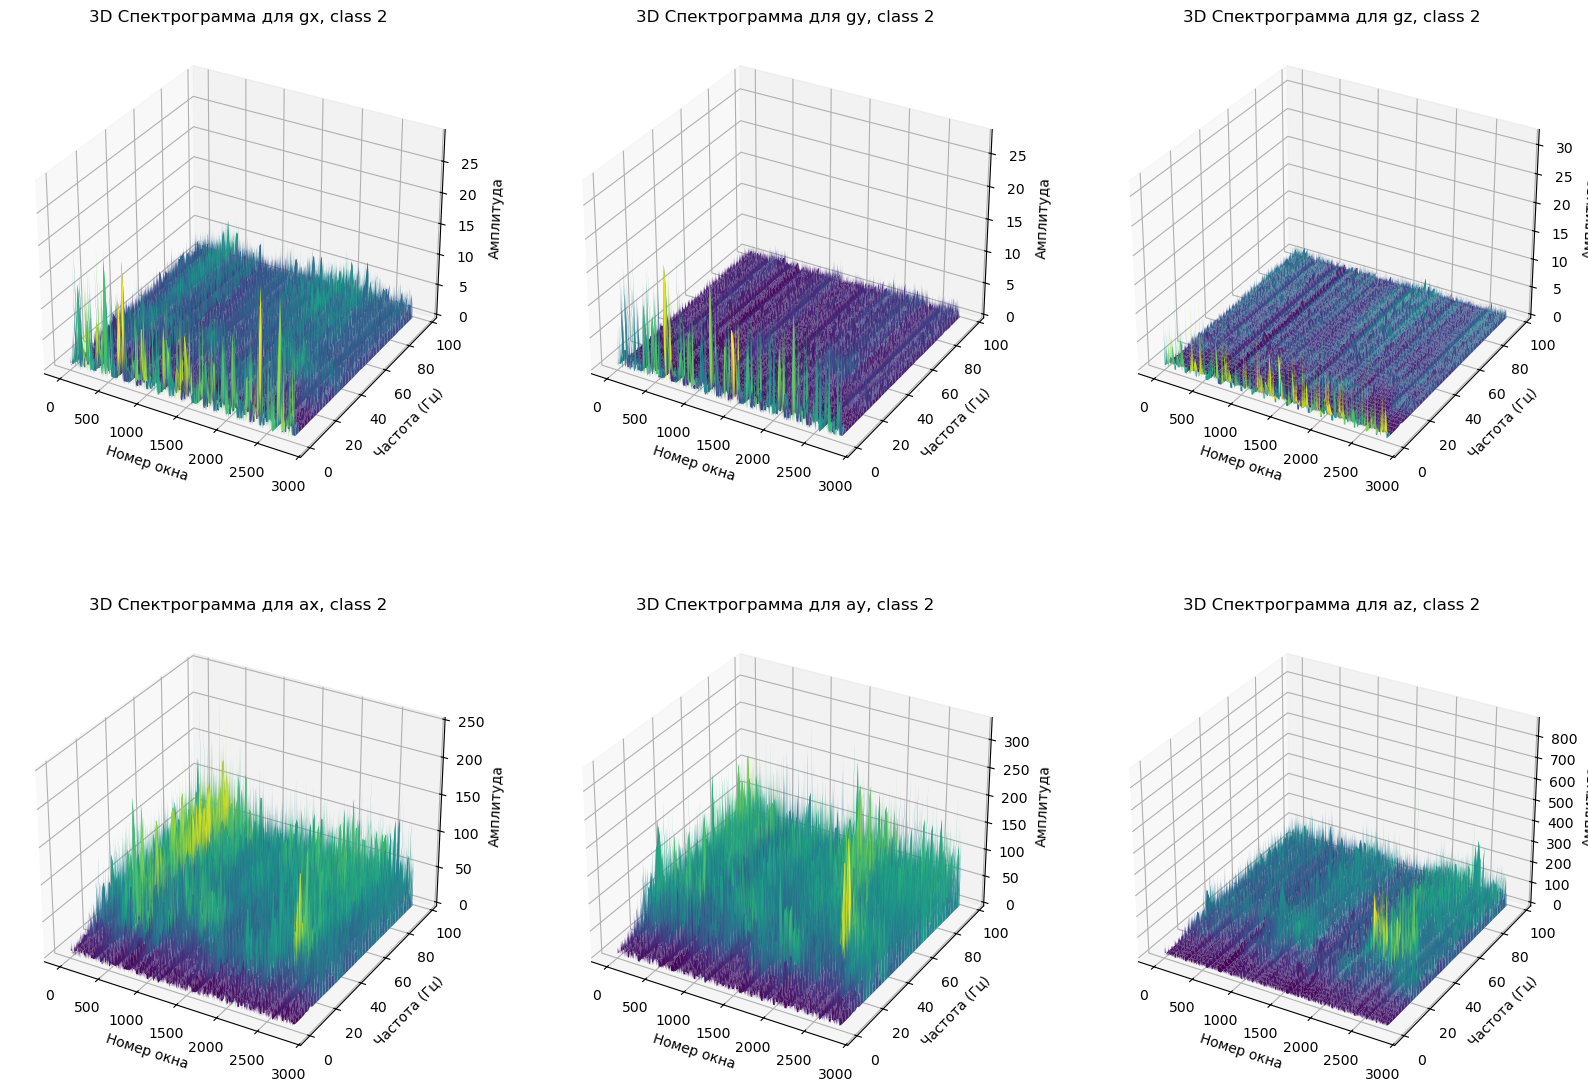

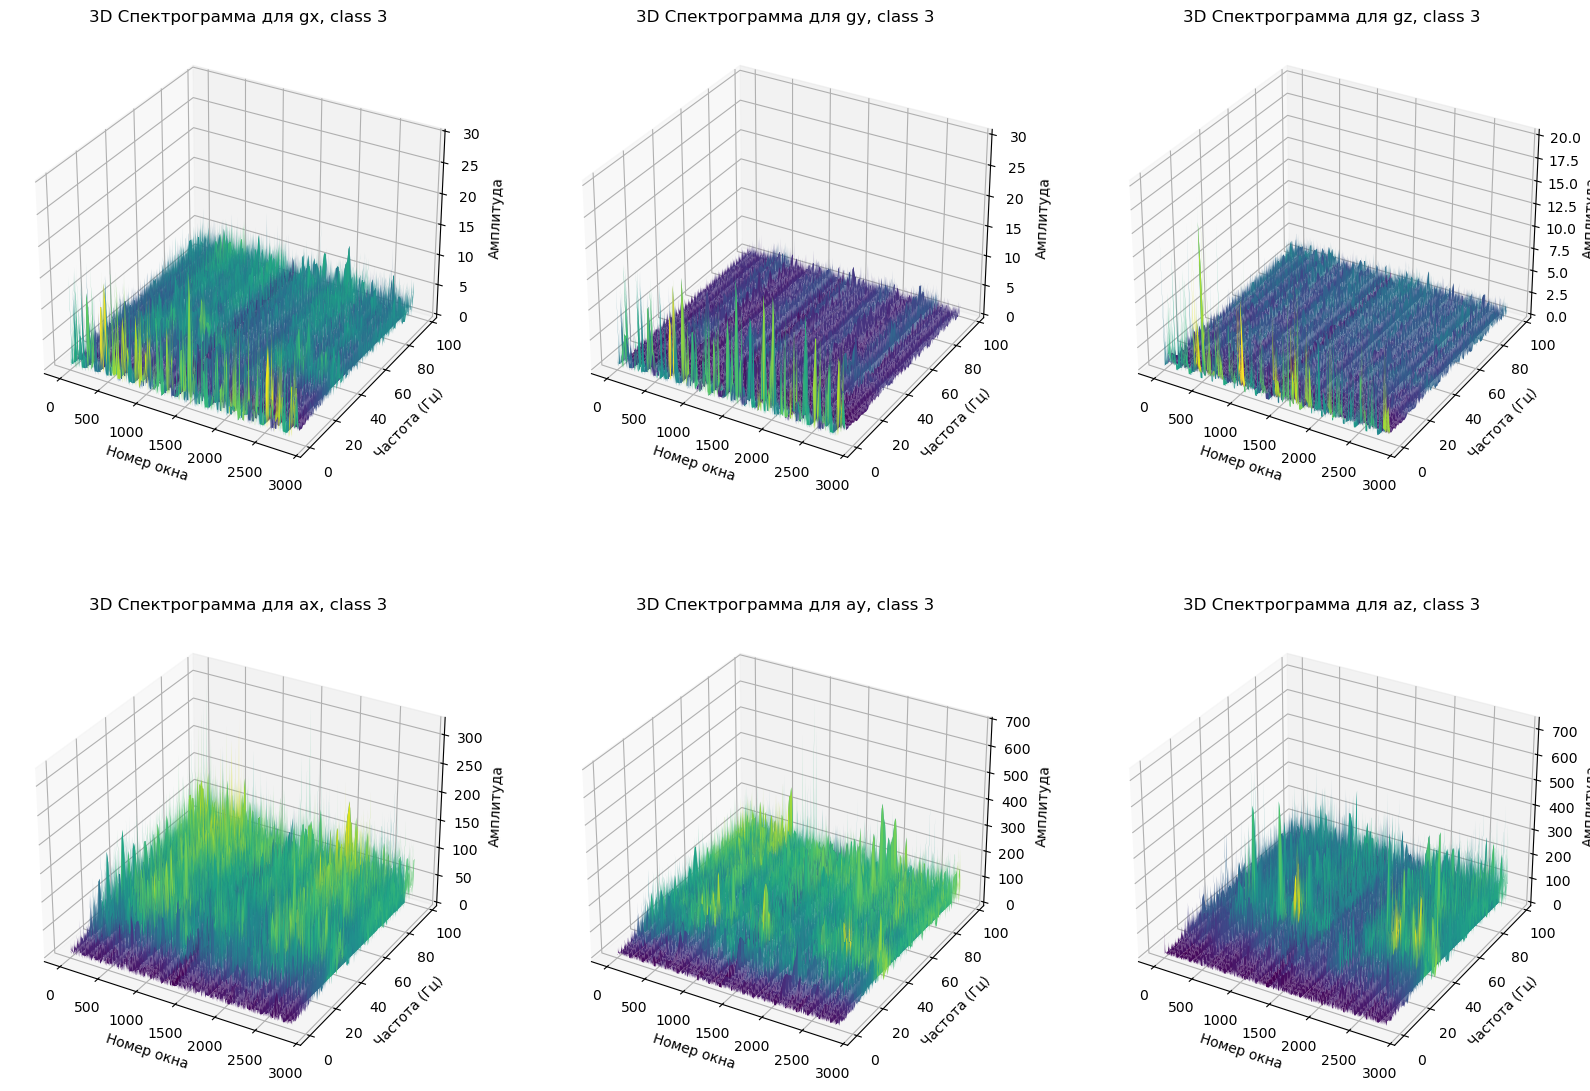

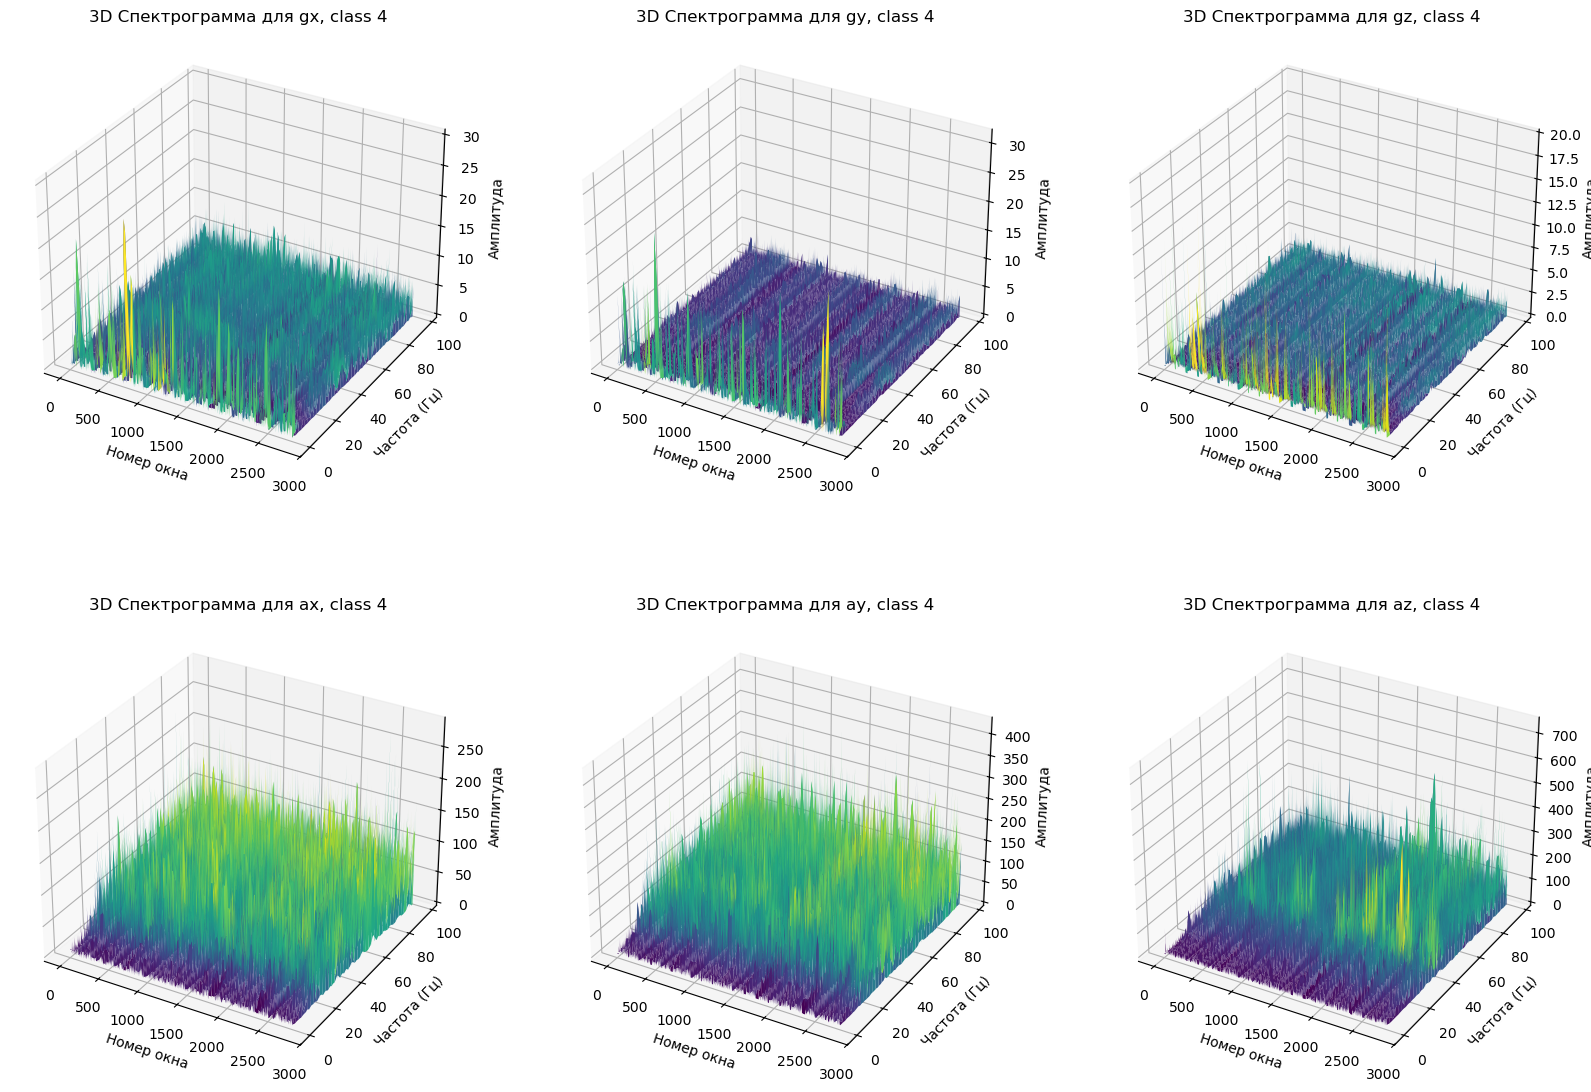

In [8]:
for i in range(5): plot_3d_spectrogram(i)

## Извлечение признаков

In [9]:
# ЧО - частотная область, ВО - временная область
cols = ["ЧО Медиана", "ЧО Средняя", 
        "ЧО Std", "ЧО Max", "ЧО Min", 
        "ЧО 90 процентиль", "ЧО 75 процентиль", "ЧО 25 процентиль", 
        "ЧО Куртозис", "ЧО Ассиметрия", "ЧО Энергия", "ЧО Вариация",
        "ЧО Количество пиков", 
        "ЧО Средняя > 10 Гц", "ЧО Std > 10 Гц", "ЧО Энергия > 10 Гц",
        
        "ВО Медиана", "ВО Средняя", 
        "ВО Std", "ВО Max", "ВО Min", 
        "ВО 90 процентиль", "ВО 75 процентиль", "ВО 25 процентиль", 
        "ВО Куртозис", "ВО Ассиметрия", "ВО Энергия", "ВО Вариация", 
        "ВО Количество пиков", 
        "ВО Общая мощность", "ВО Средняя мощность"]

channels = ["gx", "gy", "gz", "ax", "ay", "az"]
cols = sum([[col[:3] + name + col[2:] for col in cols] for name in channels], [])
cols.append("Класс")

features_df = pd.DataFrame(columns=cols)

Fs = 195                     # Частота дискретизации
window_size = 256            # Размер окна
overlap = window_size // 2   # Наложение окон (50%)

window = blackman(window_size)                     # Окно Блэкмана-Наталла
more10hz = round(256 / Fs * 10)                    # Для частот более 10 Гц
frequencies = np.fft.fftfreq(window_size, 1 / Fs)  # Получение частот для спектра

for clas in trange(5, desc='Progress', colour='blue'):
    data = pd.read_csv(rf"ProcessedDataset\{clas}\data_{clas}.csv")[["time", *channels]].values
    num_windows = (len(data) - overlap) // (window_size - overlap)  # Количество всех окон
    
    for i in trange(num_windows, desc='Progress', colour='green'):
        # Разбивка данных на перекрывающиеся сегменты
        start = i * (window_size - overlap)
        end = start + window_size
        segment = data[start:end, :]

        # Сортировка по времени и проверка "стыков" между разными фрагментами данных
        segment = pd.DataFrame(segment, columns=["time", *channels]).sort_values(by='time')
        time_differences = (segment['time'].diff().abs()).dropna()
        if max(time_differences) > 150000: continue
        segment = segment.drop(columns=["time"]).values   

        # Наложение окна, применение БПФ и извлечение признаков
        if segment.shape[0] == window_size:
            segment_windowed = segment * window[:, None]  # Наложение окна
            yf = np.fft.fft(segment_windowed, axis=0)     # Применение БПФ
            amplitude = np.abs(yf)                        # Извлечение амплитуд # shape = (num_windows, window_size, 6)
            
            features = []
            for channel in range(amplitude.shape[1]):
                amp_half = amplitude[:overlap, channel]  # Берем только положительные частоты 
                seg = segment[:, channel]

                # Частотный спектр
                features.append(np.median(amp_half))          # Медиана
                features.append(np.mean(amp_half))            # Средняя амплитуда
                features.append(np.std(amp_half))             # Стандартное отклонение
                features.append(np.max(amp_half))             # Максимальная амплитуда
                features.append(np.min(amp_half))             # Минимальная амплитуда
                features.append(np.percentile(amp_half, 90))  # 90-й процентиль
                features.append(np.percentile(amp_half, 75))  # 75-й процентиль
                features.append(np.percentile(amp_half, 25))  # 25-й процентиль
                features.append(kurtosis(amp_half))           # Куртозис
                features.append(skew(amp_half))               # Ассиметрия
                features.append(np.trapz(amp_half ** 2))      # Энергия

                # Коэффициент вариации
                features.append(np.std(amp_half) / np.mean(amp_half))  
                
                # Количество пиков (выбросов)
                features.append(np.sum(amp_half > np.median(amp_half) + 0.5 * np.std(amp_half)))

                # Исследование частот > 10 Гц
                amp_half_10 = amp_half[more10hz:]
                features.append(np.mean(amp_half_10))        # Средняя амплитуда частот > 10 Гц
                features.append(np.std(amp_half_10))         # Стандартное отклонение частот > 10 Гц
                features.append(np.trapz(amp_half_10 ** 2))  # Энергия частот > 10 Гц
            
                # Временная область
                features.append(np.median(seg))          # Медиана
                features.append(np.mean(seg))            # Средняя амплитуда
                features.append(np.std(seg))             # Стандартное отклонение
                features.append(np.max(seg))             # Максимальная амплитуда
                features.append(np.min(seg))             # Минимальная амплитуда
                features.append(np.percentile(seg, 90))  # 90-й процентиль
                features.append(np.percentile(seg, 75))  # 75-й процентиль
                features.append(np.percentile(seg, 25))  # 25-й процентиль
                features.append(kurtosis(seg))           # Куртозис
                features.append(skew(seg))               # Ассиметрия
                features.append(np.trapz(seg ** 2))      # Энергия

                # Коэффициент вариации
                features.append(np.std(seg) / np.mean(seg))  
                
                # Количество пиков (выбросов)
                features.append(np.sum(seg > np.median(seg) + 0.5 * np.std(seg)))
                
                # Плотность мощности
                f, Pxx = welch(seg, fs=Fs, window='hann', nperseg=window_size, noverlap=overlap)  
                features.append(np.sum(Pxx[:overlap]))   # Общая мощность
                features.append(np.mean(Pxx[:overlap]))  # Средняя мощность

            # Добавляем метку класса и сохраняем извлеченные признаки
            features.append(clas)
            features_df.loc[len(features_df)] = features

features_df.to_csv(f"features.csv", index=False)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Progress:   0%|          | 0/2623 [00:00<?, ?it/s]

Progress:   0%|          | 0/2896 [00:00<?, ?it/s]

Progress:   0%|          | 0/2817 [00:00<?, ?it/s]

Progress:   0%|          | 0/2846 [00:00<?, ?it/s]

Progress:   0%|          | 0/2803 [00:00<?, ?it/s]

## Построение, тестирование и сравнение моделей

In [12]:
# Загрузка данных
features_df = pd.read_csv('features.csv')
X = features_df.drop(columns = ["Класс"])
y = features_df["Класс"].values

# Разделение на обучающую и тестовую выборки
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Приведение к нормальному распределению (Преобразование Yeo-Johnson)
power_transformer = PowerTransformer(method='yeo-johnson')
X_train = power_transformer.fit_transform(X_train)
X_test = power_transformer.transform(X_test)

# Стандартизация данных
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

# Нормализация данных
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Инициализация моделей
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=4, leaf_size=1, p=1, metric='manhattan', weights='distance'),
    "Naive Bayes": GaussianNB(var_smoothing=0.1),
    "Support Vector Machine": SVC(C=800, gamma=0.1, class_weight='balanced', tol=0.01, probability=True, random_state=random_state),
    "Logistic Regression": LogisticRegression(C=300, solver='newton-cg', random_state=random_state),
    "Decision Tree": DecisionTreeClassifier(max_depth=30, criterion='entropy', random_state=random_state),
    "Perceptron": MLPClassifier(hidden_layer_sizes=(144, 256, 64, 16, 5), max_iter=400, random_state=random_state),
    "Random Forest": RandomForestClassifier(n_estimators=400, max_depth=20, random_state=random_state),
    "CatBoost": CatBoostClassifier(silent=True, random_state=random_state),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=6, random_state=random_state), n_estimators=400, learning_rate=0.1),  
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
    "Histogram-based Gradient Boosting": HistGradientBoostingClassifier(random_state=random_state),
    "XGBoost": XGBClassifier(random_state=random_state),
    "LightGBM": LGBMClassifier(verbose=-1, random_state=random_state),

    "Stacking Classifier": StackingClassifier(
        estimators=[("LGBMClassifier", LGBMClassifier(verbose=-1, random_state=random_state)),
                    ("Random Forest", RandomForestClassifier(n_estimators=400, max_depth=20, random_state=random_state)),
                    ("XGBClassifier", XGBClassifier(random_state=random_state)),
                    ("CatBoost", CatBoostClassifier(silent=True, random_state=random_state)),
                    ("Histogram-based Gradient Boosting", HistGradientBoostingClassifier(random_state=random_state)),
                    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=4, leaf_size=1, p=1, metric='manhattan', weights='distance')),
                    ("Support Vector Machine", SVC(C=800, gamma=0.1, class_weight='balanced', tol=0.01, probability=True, random_state=random_state))],
        final_estimator=LogisticRegression(random_state=random_state)),
    
    "Voting Classifier": VotingClassifier(
        estimators=[("LGBMClassifier", LGBMClassifier(verbose=-1, random_state=random_state)),
                    ("Random Forest", RandomForestClassifier(n_estimators=400, max_depth=20, random_state=random_state)),
                    ("XGBClassifier", XGBClassifier(random_state=random_state)),
                    ("CatBoost", CatBoostClassifier(silent=True, random_state=random_state)),
                    ("Histogram-based Gradient Boosting", HistGradientBoostingClassifier(random_state=random_state)),
                    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=4, leaf_size=1, p=1, metric='manhattan', weights='distance')),
                    ("Support Vector Machine", SVC(C=800, gamma=0.1, class_weight='balanced', tol=0.01, probability=True, random_state=random_state)),
                    ("Logistic Regression", LogisticRegression(C=300, solver='newton-cg', random_state=random_state)),
                    ("Perceptron", MLPClassifier(hidden_layer_sizes=(144, 256, 64, 16, 5), max_iter=400, random_state=random_state))], 
        voting='soft')
}

# Обучение и тестирование моделей
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{model_name}:\n")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred) * 100, 2)} %\n", )
    print("-" * 53)


K-Nearest Neighbors:

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       528
         1.0       0.96      0.97      0.96       561
         2.0       0.93      0.92      0.92       538
         3.0       0.89      0.89      0.89       582
         4.0       0.91      0.91      0.91       550

    accuracy                           0.93      2759
   macro avg       0.93      0.93      0.93      2759
weighted avg       0.93      0.93      0.93      2759

Accuracy: 93.29 %

-----------------------------------------------------

Naive Bayes:

              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77       528
         1.0       0.96      0.80      0.87       561
         2.0       0.87      0.50      0.64       538
         3.0       0.62      0.62      0.62       582
         4.0       0.75      0.77      0.76       550

    accuracy                           0.74      2759
   macro avg       0

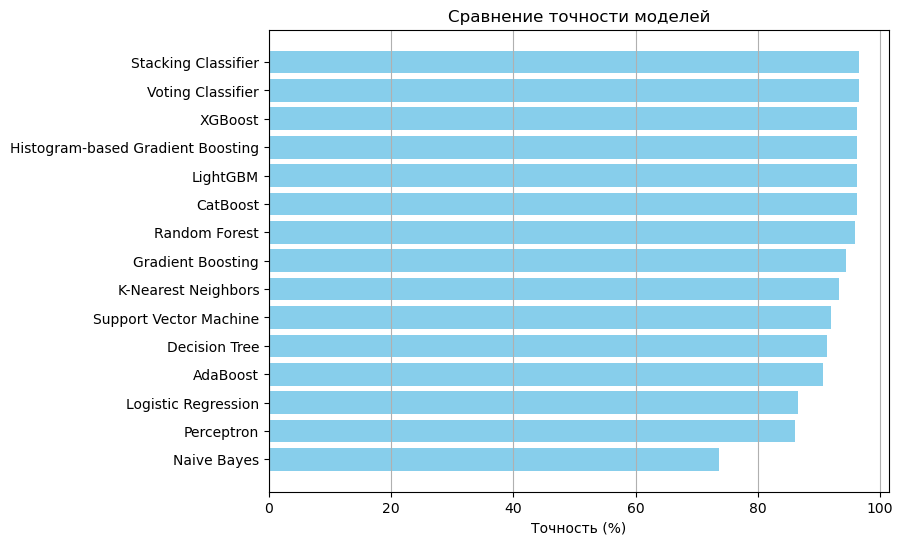

In [13]:
# Сравнение моделей по метрике точности accuracy

models_accuracy_dict = {}
for name, model in models.items():
    accuracy = accuracy_score(y_test, model.predict(X_test))
    models_accuracy_dict[name] = round(accuracy * 100, 3)

models_accuracy_df = pd.DataFrame({
    'Модель': models_accuracy_dict.keys(),
    'Точность': models_accuracy_dict.values()
})

models_accuracy_df = models_accuracy_df.sort_values(by='Точность', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(models_accuracy_df['Модель'], models_accuracy_df['Точность'], color='skyblue')
plt.xlabel('Точность (%)')
plt.title('Сравнение точности моделей')
plt.gca().invert_yaxis()
plt.grid(axis='x')
# plt.savefig('models_accuracy_comparison.png', dpi=1200, bbox_inches='tight')
plt.show()

In [14]:
# Оценка моделей по четырем метрикам точности

models_acc_dict = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    models_acc_dict[name] = {
        'Accuracy': round(accuracy * 100, 3),
        'Precision': round(precision * 100, 3),
        'Recall': round(recall * 100, 3),
        'F1 Score': round(f1 * 100, 3),
    }

models_acc_df = pd.DataFrame(models_acc_dict).T
models_acc_df = models_acc_df.sort_values(by='Accuracy', ascending=False)
models_acc_df

Accuracy  Precision  Recall  F1 Score
Stacking Classifier                  96.593     96.595  96.593    96.593
Voting Classifier                    96.484     96.486  96.484    96.484
XGBoost                              96.267     96.270  96.267    96.267
Histogram-based Gradient Boosting    96.231     96.229  96.231    96.230
LightGBM                             96.194     96.199  96.194    96.197
CatBoost                             96.158     96.155  96.158    96.154
Random Forest                        95.868     95.857  95.868    95.860
Gradient Boosting                    94.346     94.354  94.346    94.347
K-Nearest Neighbors                  93.295     93.292  93.295    93.291
Support Vector Machine               91.881     91.874  91.881    91.874
Decision Tree                        91.301     91.281  91.301    91.280
AdaBoost                             90.721     91.589  90.721    90.696
Logistic Regression                  86.589     86.625  86.589    86.592
Perceptron                           86.082     87.877  86.082    86.311
Naive Bayes                          73.686     76.717  73.686    73.304

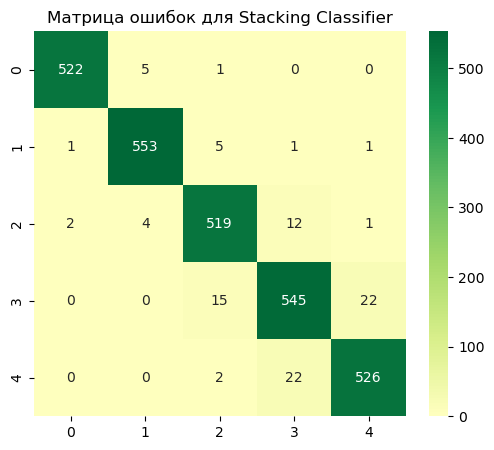

In [15]:
# Построение матрицы ошибок для Stacking Classifier

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, models.get("Stacking Classifier").predict(X_test)), 
            annot=True, 
            cmap=sns.color_palette("RdYlGn", n_colors=1000), 
            center=0, 
            fmt='d')

plt.title('Матрица ошибок для Stacking Classifier')
# plt.savefig('stacking_сlassifier_confusion_matrix.png', dpi=1200, bbox_inches='tight')
plt.show()

In [16]:
# Расчет точности с учетом ошибки в классе не более чем на 1

y_pred = models.get("Stacking Classifier").predict(X_test)

correct_predictions = 0
for true_class, predicted_class in zip(y_test, y_pred):
    if abs(true_class - predicted_class) <= 1:
        correct_predictions += 1

new_accuracy = correct_predictions / len(y_test)
print(f"Точность с учетом ошибки в классе не более чем на 1: {round(new_accuracy * 100, 2)} %")

Точность с учетом ошибки в классе не более чем на 1: 99.71 %


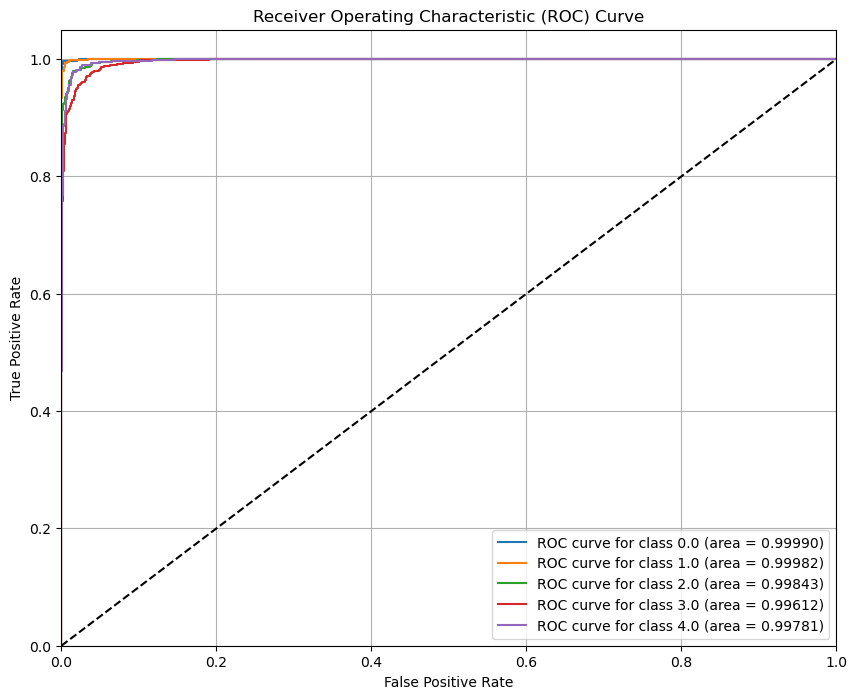

In [17]:
# Построение ROC-кривой для Stacking Classifier

voting_model = models["Stacking Classifier"]
y_score = voting_model.predict_proba(X_test)
classes = np.unique(y)

# Построение ROC-кривой для каждого класса
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test, y_score[:, i], pos_label=classes[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for class {classes[i]} (area = {roc_auc:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
# plt.savefig('stacking_classifier_roc_curve.png', dpi=1200, bbox_inches='tight')
plt.show()

#### Пример использования GridSearchCV для поиска оптимальных параметров

In [18]:
param_grid = {
    'n_neighbors': [1, 2, 3, 4, 5],
    'leaf_size': [1, 2, 3],
    'metric': ['manhattan', 'euclidean'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Лучшие параметры: ", grid_search.best_params_)
print("Лучшая оценка перекрестной проверки: ", grid_search.best_score_)

Лучшие параметры:  {'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Лучшая оценка перекрестной проверки:  0.9236128622367566


## Создание, обучение и тестирование нейронной сети

In [19]:
np.random.seed(random_state)
tf.random.set_seed(random_state)

features_df = pd.read_csv('features.csv')
X = features_df.drop(columns = ["Класс"])
y = features_df["Класс"].values
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(128, input_shape=(186,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=200, verbose=1, restore_best_weights=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
trained_model = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

Epoch 1/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4889 - loss: 1.1808 - val_accuracy: 0.8066 - val_loss: 0.4973
Epoch 2/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7538 - loss: 0.5807 - val_accuracy: 0.8320 - val_loss: 0.4059
Epoch 3/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7911 - loss: 0.4908 - val_accuracy: 0.8456 - val_loss: 0.3838
Epoch 4/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8103 - loss: 0.4466 - val_accuracy: 0.8546 - val_loss: 0.3556
Epoch 5/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8165 - loss: 0.4313 - val_accuracy: 0.8501 - val_loss: 0.3522
Epoch 6/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8297 - loss: 0.4013 - val_accuracy: 0.8379 - val_loss: 0.3868
Epoch 7/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8363 - loss: 0.3996 - val_accuracy: 0.8546 - val_loss: 0.3420
Epoch 8/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8283 - loss: 0.4052 - val_accuracy: 0.

In [20]:
# Архитектура нейронной сети

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          23,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 714,257 (2.72 MB)

 Trainable params: 238,085 (930.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 476,172 (1.82 MB)

In [21]:
# Оценка нейронной сети по четырем метрикам точности

print(classification_report(y_true, y_pred_classes))
print(f" Accuracy: {round(accuracy_score(y_true, y_pred_classes) * 100, 3)} %")
print(f"Precision: {round(precision_score(y_true, y_pred_classes, average='weighted') * 100, 3)} %")
print(f" F1-Score: {round(f1_score(y_true, y_pred_classes, average='weighted') * 100, 3)} %")
print(f"   Recall: {round(recall_score(y_true, y_pred_classes, average='weighted') * 100, 3)} %")

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       528
           1       0.94      0.95      0.95       561
           2       0.90      0.91      0.91       538
           3       0.86      0.89      0.87       582
           4       0.93      0.88      0.91       550

    accuracy                           0.92      2759
   macro avg       0.92      0.92      0.92      2759
weighted avg       0.92      0.92      0.92      2759

 Accuracy: 91.7 %
Precision: 91.758 %
 F1-Score: 91.712 %
   Recall: 91.7 %


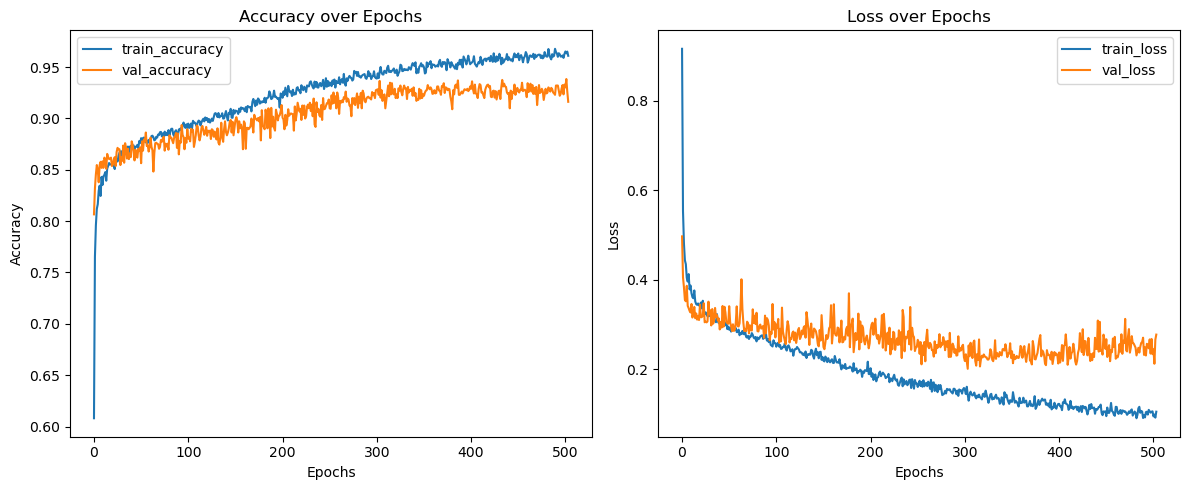

In [22]:
plt.figure(figsize=(12, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(trained_model.history['accuracy'], label='train_accuracy')
plt.plot(trained_model.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(trained_model.history['loss'], label='train_loss')
plt.plot(trained_model.history['val_loss'], label='val_loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
# plt.savefig('neural_network_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

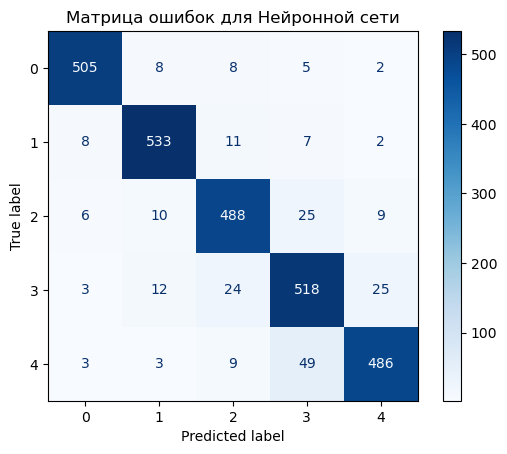

In [23]:
# Построение матрицы ошибок для нейронной сети

confMat = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred_classes), display_labels=np.arange(5))
confMat.plot(cmap=plt.cm.Blues)
plt.title('Матрица ошибок для Нейронной сети')
# plt.savefig('neural_network_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()